TO RUN THE CODE:

In [1]:
# packages
import numpy as np
from scipy.optimize import fsolve
import planet as mp
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap, ScalarMappable
from mpl_toolkits.axes_grid1 import make_axes_locatable

# local modules
import disk as ds

R_sun                   = 6.957e+8             # m
M_sun                   = 1.989e+30            # kg
M_e                     = ds.M_e
auSI                    = ds.auSI
yr                      = ds.yr
M_j                     = 1.898e27            # kg


---------------------------
---------------------------
-- Disk structure module --
---------------------------
---------------------------
   All units are SI unless stated otherwise.

-- Setting up a disk subclass: pure viscous  (Chambers 2009)
-- Setting up a disk subclass: viscous and irradiated (Chambers 2009)


Surface density and midplane temperature profiles for disk

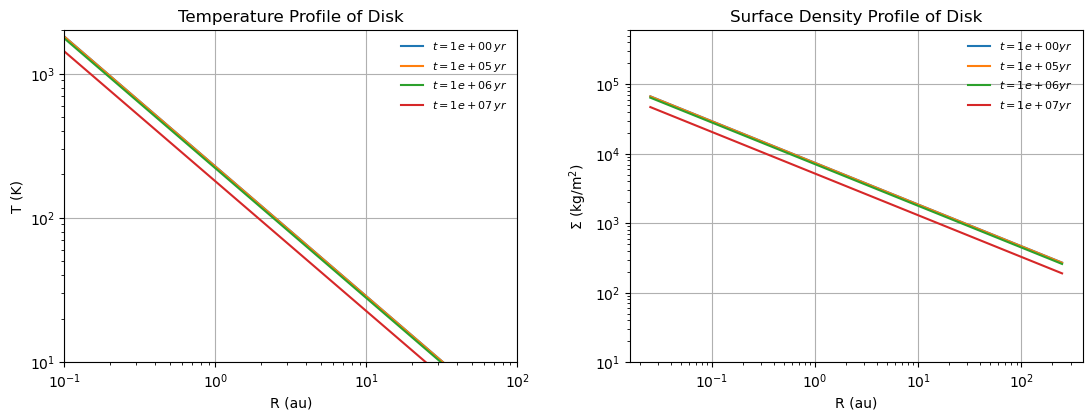

In [2]:
# List of disk models to be used
disk_models = [ds.disk_viscirr, ds.disk_visc]
# ds.disk_viscirr is disk model with heating driven by viscous transport and stellar irradiation
# ds.disk_visc is disk model with heating driven by viscous transport only

disk_args= {'disk_subclass': ds.disk_visc, 
            'M_0':0.05*M_sun,                    # kg, initial mass of disk
            'alpha':1e-4,                        # dimensionless, viscosity parameter
            's_0': 33*auSI,                      # m, initial location of disk inner edge
            'T_e': 1380.0,                       # K, initial temperature of disk midplane at inner edge 
            'M_star': 1.0*M_sun,                 # kg, mass of central star
            'T_star': 4200.0,                    # K, effective temperature of central star
            'R_star': 1.0*R_sun,                 # m, radius of central star
            'kappa_0': 0.3,                      # m^2/kg, opacity 
            'mu': 2.4,                           # dimensionless, mean molecular weight of gas in disk 
            'dtgr': 0.015,                       # dimensionless, dust-to-gas ratio in disk
            'plnr': 0.0,                         # dimensionless, fraction of planetesimals of solids
            'pebr': 0.995,                       # dimensionless, fraction of pebbles of solids
            'dustr': 0.005,                      # dimensionless, fraction of dust in solids
            'vfrag': 2.5,                         # m/s, fragmentation velocity
            'rhos': 1250}                        # kg/m^3, density of solids in disk

# Set up the disk model, chosing the disk subclass and passing the arguments
disk_model  = ds.DiskPlanetforming(**disk_args)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.tight_layout(pad=5.0)

rad_grid                       = np.array(disk_model.rstruct())
grid_sizes                     = np.diff(rad_grid) 
r_grid_centres                 = 0.5*(rad_grid[1:] + rad_grid[:-1]) 

# Plotting the temperature and surface density profiles of the disk
times = [1*yr, 1e5*yr, 1e6*yr, 1e7*yr]

axs[0].grid()
for time in [float(1*yr), float(1e5*yr), float(1e6*yr), float(1e7*yr)]:
    temps = disk_model.get_T(r_grid_centres, time, disk_model.validate(radius=r_grid_centres[1], time=time))
    axs[0].plot(r_grid_centres/auSI, temps, linewidth=1.5, label=r'$t=%.e\, yr$' % (time/yr))
axs[0].set_xscale('log')
axs[0].set_yscale('log')
axs[0].set_xlabel('R (au)')
axs[0].set_ylabel('T (K)')
axs[0].set_xlim([0.1, 100])
axs[0].set_ylim([10, 2000])
axs[0].set_title('Temperature Profile of Disk')
axs[0].legend(loc='upper right', frameon=False, fontsize=8)
axs[1].grid()
for time in [float(1*yr), float(1e5*yr), float(1e6*yr), float(1e7*yr)]:
    sigs = disk_model.get_Sigma(r_grid_centres, time, disk_model.validate(radius=r_grid_centres[1], time=time))
    axs[1].plot(r_grid_centres/auSI, sigs, linewidth=1.5, label=r'$t=%.e yr$' % (time/yr))
axs[1].set_xscale('log')
axs[1].set_yscale('log')
axs[1].set_ylim([1e1,6e5])
axs[1].set_xlabel('R (au)')
axs[1].set_ylabel(r'$\Sigma$ (kg/m$^2$)')
axs[1].set_title('Surface Density Profile of Disk')
axs[1].legend(loc='upper right', frameon=False, fontsize=8)

In [3]:
timestep_yrs     = 150          # yrs, time step of simulation
birth_time_yrs   = 1e4           # yrs, time of birth of planet

planet_args = {'a_0': 3 * ds.auSI,                  # m , birth semi-major axis of planet
               't_0': birth_time_yrs,               # yrs, birth time of planet
               'm_0' : 1e-5 * ds.M_e ,              # kg, birth mass of planet
               'B' : 4,                             # dimensionless, width of feeding zone of planetesimals in hill spheres  
               'p_ratio' : 0.5,                     # dimensionless, fraction of planetesimals adding to the mass of the envelope/core after pebble isolation mass is reached
               'dt_yrs': timestep_yrs,              # yrs, time step of simulation
               'PDM' : False,                       # boolean, whether to include planetesimal driven migration
               'migration' : True,                  # boolean, whether to include disk driven migration
               'peb_acc' : True,                    # boolean, whether to include pebble accretion
               'plan_acc' : False,                  # boolean, whether to include planetesimal accretion
               'gas_acc' : True,                    # boolean, whether to include gas accretion
               'grain_growth' : False,              # boolean, whether to include grain growth
               'pebble_drift' : False,              # boolean, whether to include pebble drift
               'disk' : disk_model}                 # disk model to be used (chosen in disk_args)

disk_model  = ds.DiskPlanetforming(**disk_args)

planet_new = mp.planet_disk_evo(**{**planet_args, 'disk': disk_model})
planet_new.single_planet_case()
array, time = planet_new.get_vals()
print(f'Birth location = {planet_new.a_0/auSI:.2f} AU \nBirth mass = {planet_new.m_0/M_e:.5f} M_e')
print(f'Final mass = {array[-1,1]/M_e:.2f} M_e \nFinal location = {array[-1,2]/auSI:.2f} AU')

indp, indc, indm, final_pebble_surface_density, final_planetesimal_grid, pebble_sigma_evo  = planet_new.get_other()

Progress: 100%|██████████| 20067/20067 [00:04<00:00, 4259.82step/s]

Birth location = 3.00 AU 
Birth mass = 0.00001 M_e
Final mass = 114.52 M_e 
Final location = 0.37 AU


/var/folders/00/pc0cznyx2_ddbf4jbvnh05yw0000gn/T/ipykernel_91248/1375912918.py:42: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = get_cmap('viridis', len(time))


(10000.0, 4000000.0)

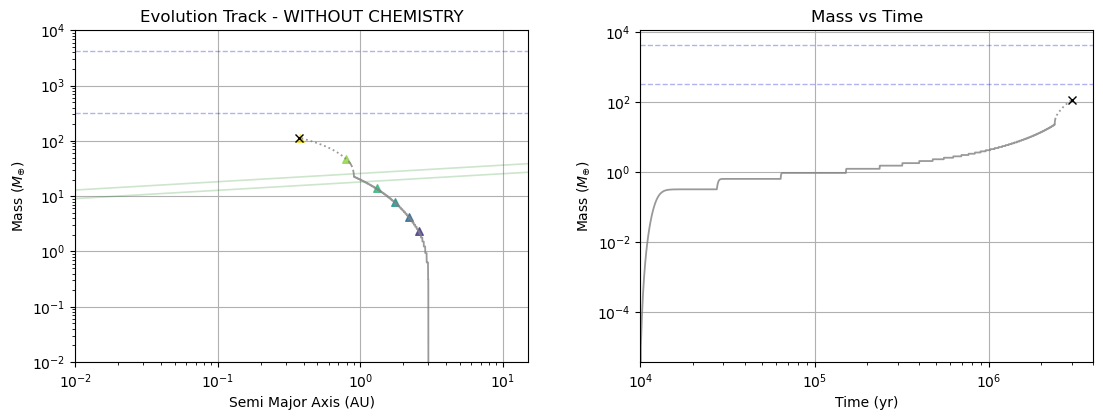

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
fig.tight_layout(pad=5.0)

# Evolution Track 
axs[0].grid()
axs[0].set_title('Evolution Track - WITHOUT CHEMISTRY')
axs[0].set_xlabel('Semi Major Axis (AU)')
axs[0].set_ylabel('Mass $(M_{\oplus})$')
axs[0].axhline((13 * M_j) / M_e, alpha=0.3, linestyle='dashed', linewidth=1, color='mediumblue')
axs[0].axhline((1 * M_j) / M_e, alpha=0.3, linestyle='dashed', linewidth=1, color='mediumblue')
axs[1].axhline((13 * M_j) / M_e, alpha=0.3, linestyle='dashed', linewidth=1, color='mediumblue')
axs[1].axhline((1 * M_j) / M_e, alpha=0.3, linestyle='dashed', linewidth=1, color='mediumblue')

radii = np.arange(0.001, 100.1, 2e-3) * auSI

# Calculate temperatures at t=0 and t=1e7*yr for all radii at once
temp_low = disk_model.get_T(time=0.0, radius=radii, status=1)
temp_high = disk_model.get_T(time=1e7*yr, radius=radii, status=1)

# Calculate pebble isolation mass for all radii at once
peb_iso_lower = disk_model.get_iso_peb(radius=radii, temperature=temp_low, status=1)
peb_iso_upper = disk_model.get_iso_peb(radius=radii, temperature=temp_high, status=1)

axs[0].loglog(radii/auSI, peb_iso_lower/M_e, alpha=0.2, color='green', linewidth=1.2)
axs[0].loglog(radii/auSI, peb_iso_upper/M_e, alpha=0.2, color='green', linewidth=1.2)

if indc is None:
    axs[0].loglog((array[:, 2]) / auSI, (array[:, 1]) / M_e, alpha=0.8, color='grey', linewidth=1.3, label='Vectorised')
    axs[1].loglog((time)/yr, array[:,1]/M_e, alpha=0.8, color='grey', linewidth=1.3)
    axs[1].plot((time[-1] )/yr, array[:,1][-1]/M_e, 'kx', markersize = 6)
    axs[0].plot(array[-1, 2] / auSI, (array[-1, 1]) / M_e, 'kx', markersize = 6)
else:
    axs[0].loglog((array[:, 2][0:indp - 1]) / auSI, (array[:, 1][0:indp - 1]) / M_e, alpha=0.8, color='grey', linewidth=1.3, label='Vectorised')
    axs[0].loglog((array[:, 2][indp:indc]) / auSI, (array[:, 1][indp:indc]) / M_e, alpha=0.8, color='grey', linewidth=1.3, linestyle='dashed')
    axs[0].loglog((array[:, 2][indc:-1]) / auSI, (array[:, 1][indc:-1]) / M_e, alpha=0.8, color='grey', linewidth=1.3, linestyle='dotted')
    axs[1].loglog((time )[0:indp - 1]/yr, array[:,1][0:indp - 1]/M_e, alpha=0.8, color='grey', linewidth=1.3)
    axs[1].loglog((time )[indp:indc]/yr, array[:,1][indp:indc]/M_e, alpha=0.8, color='grey', linewidth=1.3, linestyle='dashed')
    axs[1].loglog((time )[indc:-1]/yr, array[:,1][indc:-1]/M_e, alpha=0.8, color='grey', linewidth=1.3, linestyle='dotted')
    axs[1].plot((time[-1] )/yr, array[:,1][-1]/M_e, 'kx', markersize = 6)
    axs[0].plot(array[-1, 2] / auSI, (array[-1, 1]) / M_e, 'kx', markersize = 6)

cmap = get_cmap('viridis', len(time))
norm = mcolors.Normalize(vmin=0, vmax=np.max(time / yr - time[0] / yr))
for t in np.arange(0, np.max(time / yr - time[0] / yr), 0.5e6):  # placing markers every however many years
    idx = np.searchsorted(time / yr - time[0] / yr, t)
    if idx < len(array[:, 2]):
        a = array[:, 2][idx] / auSI
        m = array[:, 1][idx] / M_e
        axs[0].scatter(a, m, color=cmap(norm(t)), marker='^', s=30, alpha=0.8)

# Mass vs Time
axs[1].grid()
axs[1].set_title('Mass vs Time')
axs[1].set_xlabel('Time (yr)')
axs[1].set_ylabel('Mass $(M_{\oplus})$')
axs[0].set_xlim(0.01, 15)
axs[0].set_ylim(0.01, 10000)
axs[1].set_xlim(1e4, 4e6)

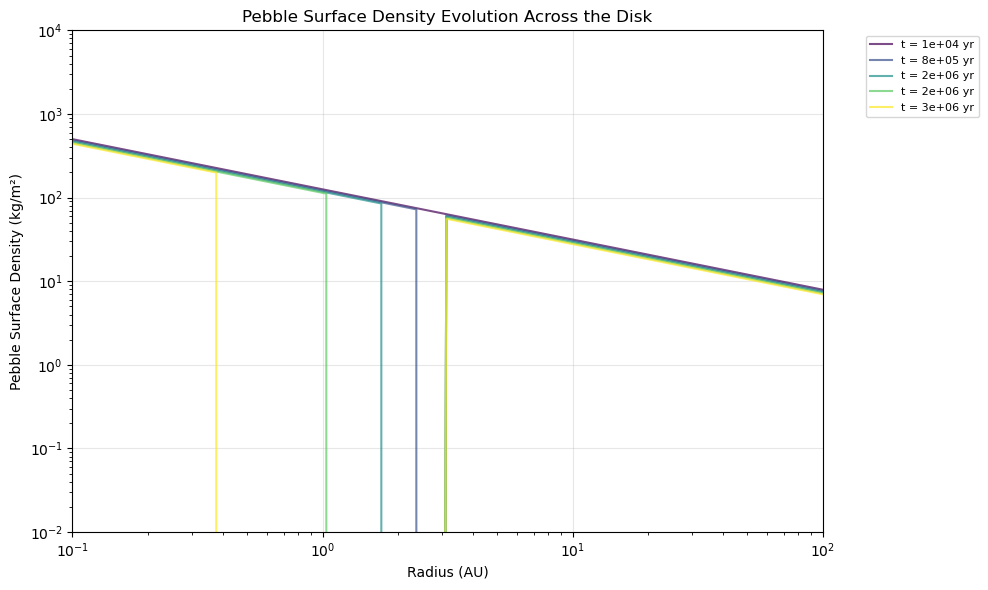

Plotted pebble surface density for 5 timesteps
Total simulation timesteps: 20067
Timestep interval: 150 years


In [5]:
# Plot pebble surface density evolution across the disk every 1000 timesteps
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# Get the radial grid
rad_grid = np.array(disk_model.rstruct())
grid_sizes = np.diff(rad_grid) 
r_grid_centres = 0.5*(rad_grid[1:] + rad_grid[:-1])

# Plot every 1000 timesteps
step_interval = 5000
total_timesteps = len(pebble_sigma_evo)

# Create a colormap for different timesteps
cmap = plt.cm.viridis
colors = cmap(np.linspace(0, 1, len(range(0, total_timesteps, step_interval))))

for i, timestep_idx in enumerate(range(0, total_timesteps, step_interval)):
    if timestep_idx < len(pebble_sigma_evo):
        # Convert timestep to actual time in years
        actual_time = (birth_time_yrs + timestep_idx * timestep_yrs)
        
        # Plot the pebble surface density at this timestep
        ax.loglog(r_grid_centres/auSI, pebble_sigma_evo[timestep_idx], 
                 color=colors[i], linewidth=1.5, alpha=0.7,
                 label=f't = {actual_time:.0e} yr')

ax.set_xlabel('Radius (AU)')
ax.set_ylabel('Pebble Surface Density (kg/m²)')
ax.set_title('Pebble Surface Density Evolution Across the Disk')
ax.grid(True, alpha=0.3)
ax.set_xlim([0.1, 100])
ax.set_ylim([1e-2, 1e4])
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

plt.tight_layout()
plt.show()

print(f"Plotted pebble surface density for {len(range(0, total_timesteps, step_interval))} timesteps")
print(f"Total simulation timesteps: {total_timesteps}")
print(f"Timestep interval: {timestep_yrs} years")

CHEMISTRY OF DISK WITHOUT PLANET FORMATION

Progress: 100%|██████████| 12040/12040 [02:22<00:00, 84.22step/s]


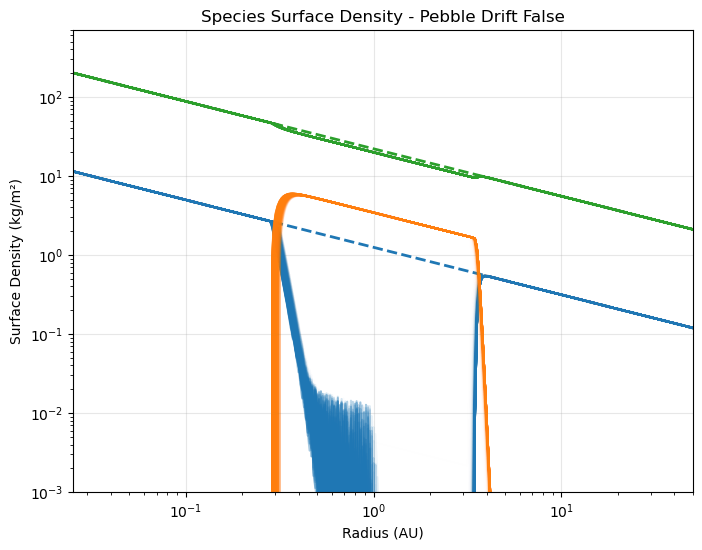

In [6]:
timestep_yrs     = 250
disk_model       = ds.DiskPlanetforming(**disk_args)
planet_free_args = {'t_f': 3.01e6, 'dt_yrs': timestep_yrs, 'grain_growth': False, 'pebble_drift': False, 'disk': disk_model}
chem_sans_planet = mp.disk_chem(**{**planet_free_args, 'disk': disk_model})
chem_sans_planet.evo_disk_case()
peb_sigma, plan_grid, pebble_evo, velocities, species_evo = chem_sans_planet.get_other()
time            = chem_sans_planet.t_range

# species labels
compound_labels = ['H2S', 'FeS_dust', 'Fe_dust']  
r_grid_centres  = planet_new.rad_grid[:-1]  
radii_au        = r_grid_centres / ds.auSI
time_years      = time / ds.yr

fig, ax         = plt.subplots(figsize=(8, 6))
compound_colors = ['tab:blue', 'tab:orange', 'tab:green']
lines           = []
plot_every      = 100                      # Adjust this value to control how many timesteps to plot

# Plot the initial surface density for each species (t=0), same color as before, dashed line
for compound_idx, color in enumerate(compound_colors):
    label = f"{compound_labels[compound_idx]} (initial)"
    ax.plot(radii_au, species_evo[0, :, compound_idx], color=color, alpha=1.0, linestyle='dashed', linewidth=2, label=label)

# Plot the time-evolving surface density for each species
n_timesteps = len(time_years)
for compound_idx, color in enumerate(compound_colors):
    label = compound_labels[compound_idx]
    for t_idx in range(0, n_timesteps, plot_every):
        alpha_val = 0.4 * (t_idx / (n_timesteps - 1))
        line, = ax.plot(radii_au, species_evo[t_idx, :, compound_idx], color=color, alpha=alpha_val, label=label if t_idx == 0 else None)
        lines.append(line)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3, 0.7e3)
ax.set_xlabel('Radius (AU)')
ax.set_ylabel('Surface Density (kg/m²)')
ax.set_title(f'Species Surface Density - Pebble Drift {planet_new.pebble_drift}')
ax.grid(alpha=0.3)

sigs = disk_model.get_Sigma(radius = r_grid_centres, time = 0.0, status = 1)
ax.plot(r_grid_centres/auSI, sigs, linewidth=1.5)

ax.set_xlim(0.025, 50)
plt.show()

PLANET CHEM STUFFFF

In [ ]:
def compute_sulfur_env_fraction(array, species_evo, pebble_evo, r_grid_centres, t_range, disk_model, dt):
    """
    Compute the final sulfur mass fraction in the gas envelope and core for a planet.
    Parameters:
        array:               (timesteps, ...) planet evolution array (key_vals)
        species_evo:         (timesteps, n_rad, n_species) species surface densities
        r_grid_centres:      (n_rad,) radial grid centres
        t_range:             (timesteps,) time array
        disk_model:          disk model object (must have get_Sigma)
        dt:                  timestep in seconds
    Returns:
        sulfur_env_fraction: final sulfur mass fraction in the envelope
        sulfur_core_fraction: final sulfur mass fraction in the core (from FeS pebbles)
    """
    species_evo = np.nan_to_num(species_evo, nan=0.0)
    timesteps, n_rad, n_species = species_evo.shape

    species_mass_gas = np.zeros(n_species)
    species_mass_core = np.zeros(n_species)

    final_env_mass = array[-1, 5]  # Envelope mass (kg)
    final_core_mass = array[-1, 6] # Core mass (kg)

    for t in range(timesteps):
        dmdt_gas = array[t, 11]
        dmdt_peb = array[t, 9]
        a_planet = array[t, 2]
        bindex = np.digitize(a_planet, r_grid_centres)
        total_gas_sigma = disk_model.get_Sigma(radius=r_grid_centres[bindex], time=t_range[t], status=1)
        total_peb_sigma = pebble_sigma_evo[t, bindex] if pebble_evo is not None else 0

        # gas accretion (H2S)
        if total_gas_sigma > 0:
            species_mass_gas[0] += dmdt_gas * dt * (species_evo[t, bindex, 0] / total_gas_sigma)

        # pebble accretion (FeS)
        if total_peb_sigma > 0:
            species_mass_core[1] += dmdt_peb * dt * (species_evo[t, bindex, 1] / total_peb_sigma)

    # H2S: 34.08 g/mol, S: 32.06 g/mol, so S mass fraction in H2S:
    sulfur_fraction_h2s = 32.06 / 34.08
    sulfur_in_env = species_mass_gas[0] * sulfur_fraction_h2s  # kg S in envelope
    if final_env_mass > 0:
        sulfur_env_fraction = sulfur_in_env / final_env_mass
        if sulfur_env_fraction < 1e-10:
            sulfur_env_fraction = 0.0
    else:
        sulfur_env_fraction = 0
    print(f' sulflur mass in envelope: {sulfur_in_env:.3e} kg, final envelope mass: {final_env_mass:.3e} kg')

    # FeS: 87.91 g/mol, S: 32.06 g/mol, so S mass fraction in FeS:
    sulfur_fraction_fes = 32.06 / 87.91
    sulfur_in_core = species_mass_core[1] * sulfur_fraction_fes  # kg S in core
    if final_core_mass > 0:
        sulfur_core_fraction = sulfur_in_core / final_core_mass
        if sulfur_core_fraction < 1e-10:
            sulfur_core_fraction = 0.0
    else:
        sulfur_core_fraction = 0
    print(f' sulflur mass in core: {sulfur_in_core:.3e} kg, final core mass: {final_core_mass:.3e} kg')

    return sulfur_env_fraction, sulfur_core_fraction

In [ ]:
import numpy as np
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.patches import Wedge
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.set_title('Envelope and Core Sulfur Mass Fraction Evolution')
ax.set_ylabel('Mass ($M_\\oplus$)')
ax.set_xlabel('Semi-major axis (AU)')
ax.set_xscale("log")
ax.set_yscale("log")        
ax.set_xlim(0.02, 50)
ax.set_ylim(1e-2, 1e4)  
ax.axhline((1*M_j)/M_e, alpha = 0.3, linewidth= 1, color= 'darkorchid', label='Jupiter Mass')
ax.grid(alpha=0.3)

disk_args   = {'disk_subclass': ds.disk_viscirr, 
               'M_0':0.05*M_sun,                    # kg, initial mass of disk
               'alpha':1e-4,                        # dimensionless, viscosity parameter
               's_0': 33*auSI,                      # m, initial location of disk inner edge
               'T_e': 1380.0,                       # K, initial temperature of disk midplane at inner edge 
               'M_star': 1.0*M_sun,                 # kg, mass of central star
               'T_star': 4200.0,                    # K, effective temperature of central star
               'R_star': 1.0*R_sun,                 # m, radius of central star
               'kappa_0': 0.3,                      # m^2/kg, opacity 
               'mu': 2.4,                           # dimensionless, mean molecular weight of gas in disk 
               'dtgr': 0.015,                       # dimensionless, dust-to-gas ratio in disk
               'plnr': 0.0,                         # dimensionless, fraction of planetesimals of solids
               'pebr': 0.995,                       # dimensionless, fraction of pebbles of solids
               'dustr': 0.005,                      # dimensionless, fraction of dust in solids
               'vfrag': 2.5,                         # m/s, fragmentation velocity
               'rhos': 1250}                        # kg/m^3, density of solids in disk

timestep_yrs     = 10
disk_model       = ds.DiskPlanetforming(**disk_args)

radii = np.arange(0.001, 100.1, 2e-3) * auSI
temp_low = disk_model.get_T(time=0.0, radius=radii, status=1)
temp_high = disk_model.get_T(time=3.01e6*yr, radius=radii, status=1)
peb_iso_lower = disk_model.get_iso_peb(radius=radii, temperature=temp_low, status=1)
peb_iso_upper = disk_model.get_iso_peb(radius=radii, temperature=temp_high, status=1)
peb_iso_min = np.minimum(peb_iso_lower, peb_iso_upper)
peb_iso_max = np.maximum(peb_iso_lower, peb_iso_upper)
ax.fill_between(radii/auSI, peb_iso_min/M_e, peb_iso_max/M_e, color='powderblue', alpha=1, label='Pebble isolation mass range')

norm_env = mcolors.LogNorm(vmin=1e-7, vmax=1e-2)
norm_core = mcolors.LogNorm(vmin=1e-7, vmax=1e-2)
cmap_sulf = plt.get_cmap("viridis", 10)
sm_env = plt.cm.ScalarMappable(cmap=cmap_sulf, norm=norm_env)
sm_core = plt.cm.ScalarMappable(cmap=cmap_sulf, norm=norm_core)
sm_env.set_array([])
sm_core.set_array([])

In [ ]:
a_0_range = np.array([0.1, 0.5, 0.75, 1, 2, 3, 5, 7, 8.5, 10, 20, 30])  # RUN ONE AT A TIME
a_0_range = np.array([1]) 

timestep_yrs = 50 # years, time step of simulation

for a in a_0_range:
    birth_time = 1e4
    birth_loc = a
    disk_model = ds.DiskPlanetforming(**disk_args)
    print(f'birth_time = {float(birth_time):.2e} yrs, birth_loc = {float(birth_loc):.2f} AU')        
    planet_args = {'a_0': birth_loc * auSI,
                't_0': birth_time,             
                'm_0' : 1e-5 * ds.M_e ,          
                'B' : 4,                        
                'p_ratio' : 0.5,    
                'dt_yrs': timestep_yrs,                  
                'PDM' : False,           
                'migration' : True,          
                'peb_acc' : True,           
                'plan_acc' : False,             
                'gas_acc' : True,                
                'grain_growth' : False,           
                'pebble_drift' : False,        
                'disk' : disk_model} 
                    
    planet = mp.planet_disk_chem(**{**planet_args, 'disk': disk_model})
    planet.single_planet_case()
    array, time, st = planet.get_vals()

    print(f'Final mass = {array[-1,1]/M_e:.2f} M_e \n Final location = {array[-1,2]/auSI:.2f} AU')

    indp, indc, indm, final_pebble_surface_density, final_planetesimal_grid, pebble_sigma_evo, species_evo = planet.get_other()

    # Compute sulfur fraction in envelope and core
    sulfur_env_fraction, sulfur_core_fraction = compute_sulfur_env_fraction(array, species_evo, pebble_sigma_evo, planet.r_grid_centres, planet.t_range, disk_model, planet.dt)

    print(f'Sulfur fraction in envelope: {sulfur_env_fraction:.3e}')
    print(f'Sulfur fraction in core: {sulfur_core_fraction:.3e}')

    cmap_time = plt.colormaps['plasma']
    norm = mcolors.Normalize(vmin=0, vmax=np.max(time/yr - birth_time))

    for t in np.arange(0, np.max(time/yr - birth_time), 0.5e6): # placing markers every however many years
        idx = np.searchsorted(time/yr - birth_time, t)
        if idx < len(array[:, 2]):
            a = array[:, 2][idx] / auSI
            m = array[:, 1][idx] / M_e
            ax.scatter(a, m, color=cmap_time(norm(t)), marker='^', s=30, alpha=0.5)

    # plot planet track on ax
    color_track = 'gray' #cmap_time(norm(birth_time - t_0_range[0]))

    if indc is None:
        ax.plot(array[:, 2] / auSI, array[:, 1] / M_e, color=color_track, linewidth=1.4, alpha=1)
    else:
        ax.plot(array[:, 2][0:indp - 1] / auSI, array[:, 1][0:indp - 1] / M_e, color=color_track, linewidth=1.4, alpha=1)
        ax.plot(array[:, 2][indp:indc] / auSI, array[:, 1][indp:indc] / M_e, color=color_track, linewidth=1.4, alpha=1, linestyle="dashed")
        ax.plot(array[:, 2][indc:-1] / auSI, array[:, 1][indc:-1] / M_e, color=color_track, linewidth=1.4, alpha=1, linestyle="dotted")

    final_a = array[-1, 2] / auSI
    final_m = array[-1, 1] / M_e

    marker_size = 200  # size for scatter marker

    if sulfur_env_fraction == 0:
        env_color = 'white'
    else:
        env_color = cmap_sulf(norm_env(sulfur_env_fraction))
    
    if sulfur_core_fraction == 0:
        core_color = 'white'
    else:
        core_color = cmap_sulf(norm_core(sulfur_core_fraction))

    # envelope color (larger marker)
    ax.scatter(final_a, final_m, 
               s=marker_size, 
               color=env_color, 
               edgecolor="black", 
               linewidth=0.8, 
               zorder=10)

    # core color (smaller marker on top)
    ax.scatter(final_a, final_m, 
               s=marker_size * 0.35, 
               color=core_color, 
               edgecolor="white", 
               linewidth=0.8, 
               zorder=11)


divider = make_axes_locatable(ax)
cax_sulf = divider.append_axes("right", size="3%", pad=0.05)

cbar_env = plt.colorbar(sm_env, cax=cax_sulf)
cbar_env.set_label("Sulfur mass fraction in envelope & core", fontsize=10)
plt.show()